<a href="https://colab.research.google.com/github/arjoca/RHDocentes/blob/main/RHDocentes_08022022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Índice

# Narrativa

# Fontes de informação

*   Ficheiro "Afetacao_Financeira_ADs_Cursos_2021_v01.xlsx"
*   Ficheiro "RAIDES_0.xlsx"

Informação que depois de filtrada e anonimizada deu origem aos dados guardados no ficheiro [clean_data.xlsx](https://github.com/arjoca/RHDocentes/blob/main/clean_data.xlsx), usados neste estudo.

# Preparação

## Importação de módulos e leitura de dados

In [1]:
# Importação de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Leitura de dados
base_url = 'https://raw.githubusercontent.com/arjoca/RHDocentes/main/'
docentes = pd.read_csv(base_url + 'docentes.csv', encoding= 'unicode_escape', 
                       parse_dates=['Data Nascimento'], infer_datetime_format=True)
alunos_per_curso = pd.read_csv(base_url + 'alunos.csv', encoding= 'unicode_escape', index_col=0)
horas = pd.read_csv(base_url + 'horas.csv', encoding= 'unicode_escape', index_col=0)

## Inicializações

In [3]:
# Formatação de números decimais
pd.options.display.float_format = "{:,.1f}".format

In [4]:
# Designações dos cursos e departamentos
LISTA_DEPTS = docentes['Departamento'].unique()
LISTA_CURSOS = alunos_per_curso.index.unique()

In [5]:
# Designações das categorias de docentes
cat_prof_coord = ['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']
cat_convidado = ['Assistente Convidado', 'Professor Adjunto Convidado']
cat_adjunto = ['Professor Adjunto']
cat_assistente = ['Assistente do 2. Trienio', 'Assistente', 'Equiparado Assistente 2. Trienio']
cat_monitor = ['Monitor']
cat_quadro = cat_prof_coord + cat_adjunto
cat_todas = cat_quadro + cat_convidado + cat_assistente + cat_monitor

## Definição de funções

In [6]:
# Filtragem de docentes atendendo à sua idade de aposentação 
def aposentados_e_ativos(df, ano, idade_reforma):
  idade = (datetime(ano, 1, 1) - df['Data Nascimento'])/timedelta(days=365.25)
  aposentados = df[idade > idade_reforma]
  ativos = df.drop(index=aposentados.index)
  return aposentados, ativos

In [7]:
# Filtragem de docentes atendendo à sua categoria
def docentes_per_categoria(df, categoria):
  s = df.groupby(['Departamento', 'Categoria'])['ETI'].count()
  s = s.loc[(slice(None), categoria)].droplevel(level=1)
  s = s.groupby(s.index).sum()
  s = pd.Series(s, index=LISTA_DEPTS)
  return s.fillna(0)

In [8]:
# Prepara para visualizar hierarquias de dados (tipo treemaps)
def prepare_to_treemap(tabela_horas, dept=None, threshold_percentage=0.01):
  s = tabela_horas[dept].copy() if dept is not None else tabela_horas.sum(axis=1)
  total = s.values.sum()
  threshold = threshold_percentage * total
  s = s[s > threshold]
  remainder = total - s.values.sum()
  s = s.append(pd.Series(data=[remainder], index=['OUTROS']))
  return s.sort_values(ascending=False)

In [9]:
# Gráfico simples com barras/tabela e linha de referência
def plot_table_series(s, title='', ref=None, size=(12,3)):
  fig, ax = plt.subplots(1, 1, figsize=size)
  s.name = ''
  df = s.to_frame()
  df.plot(kind='bar', table=np.round(df.T, 1), ax=ax, legend=None)
  if ref is not None:
    ax.axhline(y=ref, linewidth=2, color='#d62728')
  ax.xaxis.set_visible(False)
  ax.set_title(title);

# Exploração de dados

## Fotografia do ISEL (hoje)

In [10]:
# Horas de contacto usadas para determinar relações entre cursos e departamentos
horas_per_dept = horas.sum()
horas_per_curso = horas.sum(axis=1)

pesos_dept_per_curso = horas.T / horas_per_curso
pesos_curso_per_dept = horas / horas_per_dept

# Alunos por departamento
alunos_per_dept = pd.DataFrame(np.dot(pesos_dept_per_curso, alunos_per_curso),
                              index=pesos_dept_per_curso.index, columns=['Alunos'])
alunos_per_curso = alunos_per_curso['Alunos']
alunos_per_dept = alunos_per_dept['Alunos']
alunos_per_dept.name = ''
alunos_per_dept = alunos_per_dept.sort_index()

# ETIs e rácios alunos/ETI
eti_per_dept = docentes.groupby(['Departamento'])['ETI'].sum()
eti_per_dept.name = ''
alunos_per_eti_isel = alunos_per_dept.sum() / eti_per_dept.sum()
alunos_per_eti_dept = alunos_per_dept / eti_per_dept

### Visão geral

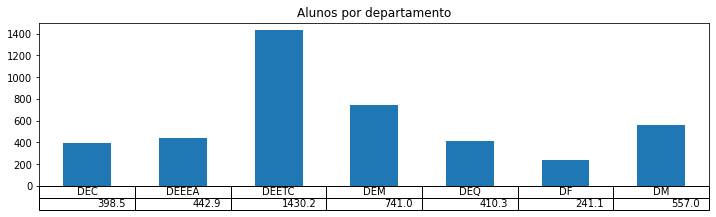

In [11]:
# Alunos por departamento
plot_table_series(alunos_per_dept, 'Alunos por departamento')

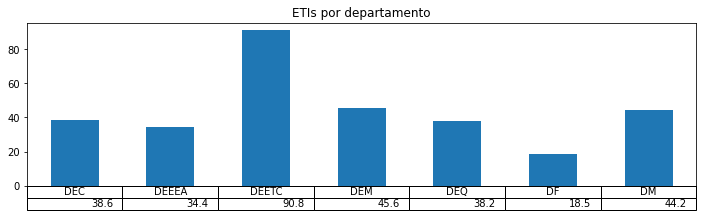

In [12]:
# ETIs por departamento
plot_table_series(eti_per_dept, 'ETIs por departamento')

### Assimetrias

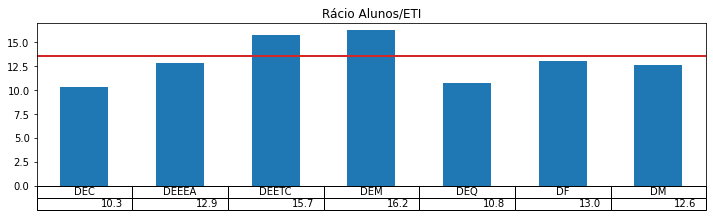

In [13]:
# Rácio Alunos / ETI
plot_table_series(alunos_per_dept / eti_per_dept, 'Rácio Alunos/ETI', 
            ref=alunos_per_eti_isel)

### Eficiências relativas dos departamentos

In [14]:
# Eficiência relativa dos departamentos/cursos
alunos_per_hora_isel = alunos_per_dept.sum() / horas_per_dept.sum()
horas_per_eti_isel = horas_per_curso.sum() / eti_per_dept.sum()
eff_alunos_per_hora_dept = 100 * alunos_per_dept / horas_per_dept / alunos_per_hora_isel
eff_horas_per_eti_dept = 100 * horas_per_dept / eti_per_dept / horas_per_eti_isel
eff_alunos_per_hora_curso = 100 * alunos_per_curso / horas_per_curso / alunos_per_hora_isel
eff_alunos_per_hora_curso.dropna(inplace=True)

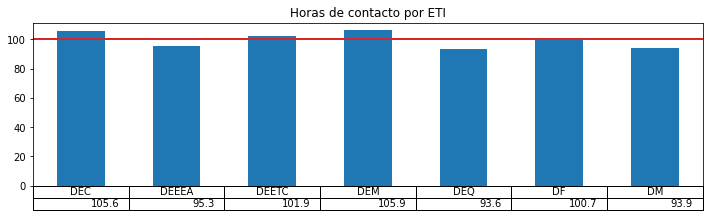

In [15]:
# Horas de contacto por ETI
plot_table_series(eff_horas_per_eti_dept, 'Horas de contacto por ETI', 
            ref=100)

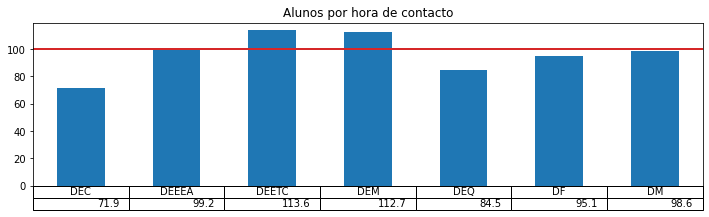

In [16]:
# Alunos por hora de contacto
plot_table_series(eff_alunos_per_hora_dept, 'Alunos por hora de contacto', ref=100)


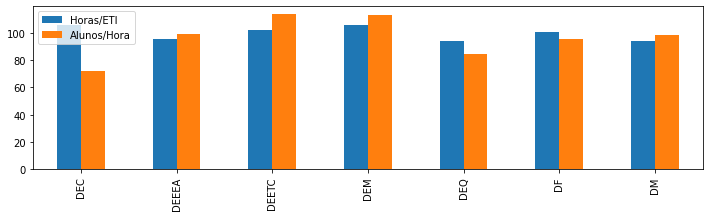

In [17]:

fig, ax = plt.subplots(1, 1, figsize=(12,3))
df = pd.DataFrame(data={'Horas/ETI':eff_horas_per_eti_dept,'Alunos/Hora':eff_alunos_per_hora_dept})
df.plot(kind='bar', ax=ax);

Notar que:

$\frac{\text{Alunos}}{\text{ETI}} = \frac{\text{Hora}}{\text{ETI}} \frac{\text{Alunos}}{\text{Hora}}$ 

Carga docente x Dimensão de turmas

### Eficiência relativa de cada curso

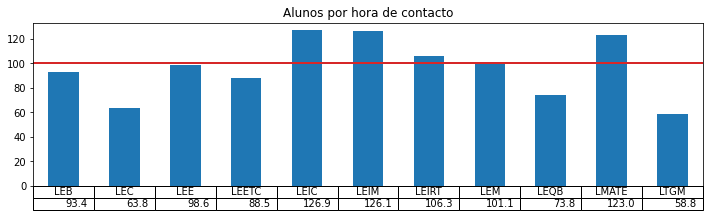

In [18]:
# Figura com eficiência relativa de cada curso (licenciatura)
plot_table_series(eff_alunos_per_hora_curso[:11], 'Alunos por hora de contacto', ref=100)

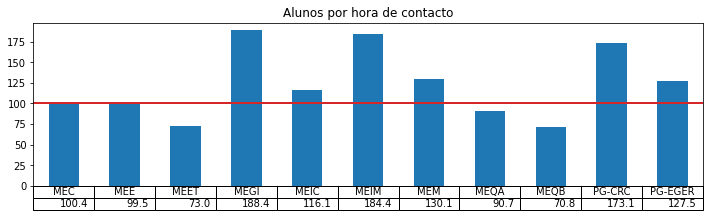

In [19]:
# Figura com eficiência relativa de cada curso (mestrado)
plot_table_series(eff_alunos_per_hora_curso[11:], 'Alunos por hora de contacto', ref=100)

### ETIs em Falta

In [20]:
# VIANA (Valor Ideal Atendendo ao Número de Alunos)
# FANA (em Falta Atendendo ao Número de Alunos)
alunos_per_eti_ideal = alunos_per_eti_isel
viana = alunos_per_dept / alunos_per_eti_ideal
fana = viana - eti_per_dept

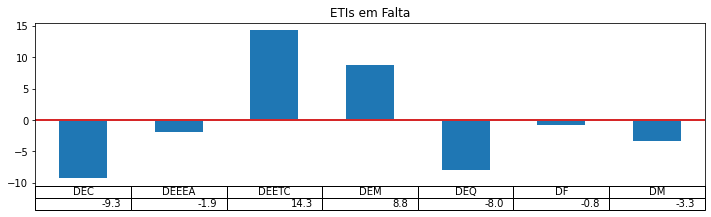

In [21]:
plot_table_series(fana, 'ETIs em Falta', ref=0)

## Olhar para o Futuro